# Ekstraksi Kata Kunci Berita Online

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/ppw/ppw_implementasi/tugas ppw/dataset/berita_kompas.csv')
data

,Judul_Artikel,Tanggal Publish,Content_Artikel,Category
0,Jadwal Timnas Indonesia Malam Ini di Piala Dun...,"13/11/2023, 14:14 WIB",KOMPAS.com - Jadwal timnas Indonesia malam ini...,Sports
1,Eks Pelatih Garuda soal 2 Pemain Keturunan di ...,"13/11/2023, 13:20 WIB",KOMPAS.com - Keberadaan dua pemain keturunan d...,Sports
2,Cerita Jurnalis Mali di Piala Dunia U17: Dari ...,"13/11/2023, 12:15 WIB",KOMPAS.com - Dua jurnalis Mali hadir langsung ...,Sports
3,"Piala Dunia U17 2023, Jurnalis Ekuador Bicara ...","13/11/2023, 11:30 WIB","Laporan langsung jurnalis Kompas.com, Ahmad Zi...",Sports
4,5 MVP Turnamen Bold Battle of Legends 2023 Jal...,"13/11/2023, 11:03 WIB",KOMPAS.com - Rangkaian turnamen esports Bold B...,Sports
...,...,...,...,...
805,Penunggak Pajak Kendaraan Diumumkan di SPBU Be...,"08/11/2023, 06:22 WIB","JAKARTA, KOMPAS.com - Corporate Secretary Pert...",Otomotif
806,[POPULER OTOMOTIF] Intip Bodi Bus Langka Milik...,"08/11/2023, 06:02 WIB","JAKARTA, KOMPAS.com - Seiring perubahan zaman ...",Otomotif
807,"Subaru DriveFest di Batam, Tutup Perayaan 50 T...","07/11/2023, 20:21 WIB","JAKARTA, KOMPAS.com - Subaru Indonesia menggel...",Otomotif
808,"Ada Balap Resmi, Bamsoet Minta Pengguna Moge T...","07/11/2023, 20:11 WIB","JAKARTA, KOMPAS.com - Salah satu grup terbesar...",Otomotif


In [3]:
# Hitung jumlah kelas
kelas = data['Category'].value_counts()
kelas

Sports      270
Edukasi     270
Otomotif    270
Name: Category, dtype: int64

In [4]:
data.isnull().sum()

Judul_Artikel      0
Tanggal Publish    0
Content_Artikel    0
Category           0
dtype: int64

In [5]:
data.duplicated().sum()

0

### Clean data

In [6]:
import re
data['clean_content'] = data['Content_Artikel'].str.replace(r'[^\w\s,.?!]', '', regex=True).str.lower()
data

,Judul_Artikel,Tanggal Publish,Content_Artikel,Category,clean_content
0,Jadwal Timnas Indonesia Malam Ini di Piala Dun...,"13/11/2023, 14:14 WIB",KOMPAS.com - Jadwal timnas Indonesia malam ini...,Sports,kompas.com jadwal timnas indonesia malam ini ...
1,Eks Pelatih Garuda soal 2 Pemain Keturunan di ...,"13/11/2023, 13:20 WIB",KOMPAS.com - Keberadaan dua pemain keturunan d...,Sports,kompas.com keberadaan dua pemain keturunan di...
2,Cerita Jurnalis Mali di Piala Dunia U17: Dari ...,"13/11/2023, 12:15 WIB",KOMPAS.com - Dua jurnalis Mali hadir langsung ...,Sports,kompas.com dua jurnalis mali hadir langsung k...
3,"Piala Dunia U17 2023, Jurnalis Ekuador Bicara ...","13/11/2023, 11:30 WIB","Laporan langsung jurnalis Kompas.com, Ahmad Zi...",Sports,"laporan langsung jurnalis kompas.com, ahmad zi..."
4,5 MVP Turnamen Bold Battle of Legends 2023 Jal...,"13/11/2023, 11:03 WIB",KOMPAS.com - Rangkaian turnamen esports Bold B...,Sports,kompas.com rangkaian turnamen esports bold ba...
...,...,...,...,...,...
805,Penunggak Pajak Kendaraan Diumumkan di SPBU Be...,"08/11/2023, 06:22 WIB","JAKARTA, KOMPAS.com - Corporate Secretary Pert...",Otomotif,"jakarta, kompas.com corporate secretary perta..."
806,[POPULER OTOMOTIF] Intip Bodi Bus Langka Milik...,"08/11/2023, 06:02 WIB","JAKARTA, KOMPAS.com - Seiring perubahan zaman ...",Otomotif,"jakarta, kompas.com seiring perubahan zaman d..."
807,"Subaru DriveFest di Batam, Tutup Perayaan 50 T...","07/11/2023, 20:21 WIB","JAKARTA, KOMPAS.com - Subaru Indonesia menggel...",Otomotif,"jakarta, kompas.com subaru indonesia menggela..."
808,"Ada Balap Resmi, Bamsoet Minta Pengguna Moge T...","07/11/2023, 20:11 WIB","JAKARTA, KOMPAS.com - Salah satu grup terbesar...",Otomotif,"jakarta, kompas.com salah satu grup terbesar ..."


### Tokenizing

In [7]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

# Download kamus stop words
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
data["tokenizing"] = data['clean_content'].apply(sent_tokenize)
data

,Judul_Artikel,Tanggal Publish,Content_Artikel,Category,clean_content,tokenizing
0,Jadwal Timnas Indonesia Malam Ini di Piala Dun...,"13/11/2023, 14:14 WIB",KOMPAS.com - Jadwal timnas Indonesia malam ini...,Sports,kompas.com jadwal timnas indonesia malam ini ...,[kompas.com jadwal timnas indonesia malam ini...
1,Eks Pelatih Garuda soal 2 Pemain Keturunan di ...,"13/11/2023, 13:20 WIB",KOMPAS.com - Keberadaan dua pemain keturunan d...,Sports,kompas.com keberadaan dua pemain keturunan di...,[kompas.com keberadaan dua pemain keturunan d...
2,Cerita Jurnalis Mali di Piala Dunia U17: Dari ...,"13/11/2023, 12:15 WIB",KOMPAS.com - Dua jurnalis Mali hadir langsung ...,Sports,kompas.com dua jurnalis mali hadir langsung k...,[kompas.com dua jurnalis mali hadir langsung ...
3,"Piala Dunia U17 2023, Jurnalis Ekuador Bicara ...","13/11/2023, 11:30 WIB","Laporan langsung jurnalis Kompas.com, Ahmad Zi...",Sports,"laporan langsung jurnalis kompas.com, ahmad zi...","[laporan langsung jurnalis kompas.com, ahmad z..."
4,5 MVP Turnamen Bold Battle of Legends 2023 Jal...,"13/11/2023, 11:03 WIB",KOMPAS.com - Rangkaian turnamen esports Bold B...,Sports,kompas.com rangkaian turnamen esports bold ba...,[kompas.com rangkaian turnamen esports bold b...
...,...,...,...,...,...,...
805,Penunggak Pajak Kendaraan Diumumkan di SPBU Be...,"08/11/2023, 06:22 WIB","JAKARTA, KOMPAS.com - Corporate Secretary Pert...",Otomotif,"jakarta, kompas.com corporate secretary perta...","[jakarta, kompas.com corporate secretary pert..."
806,[POPULER OTOMOTIF] Intip Bodi Bus Langka Milik...,"08/11/2023, 06:02 WIB","JAKARTA, KOMPAS.com - Seiring perubahan zaman ...",Otomotif,"jakarta, kompas.com seiring perubahan zaman d...","[jakarta, kompas.com seiring perubahan zaman ..."
807,"Subaru DriveFest di Batam, Tutup Perayaan 50 T...","07/11/2023, 20:21 WIB","JAKARTA, KOMPAS.com - Subaru Indonesia menggel...",Otomotif,"jakarta, kompas.com subaru indonesia menggela...","[jakarta, kompas.com subaru indonesia menggel..."
808,"Ada Balap Resmi, Bamsoet Minta Pengguna Moge T...","07/11/2023, 20:11 WIB","JAKARTA, KOMPAS.com - Salah satu grup terbesar...",Otomotif,"jakarta, kompas.com salah satu grup terbesar ...","[jakarta, kompas.com salah satu grup terbesar..."


### Ekstraksi Kata Kunci

In [9]:
corpus = data["tokenizing"][0]
corpus

['kompas.com  jadwal timnas indonesia malam ini pada lanjutan babak penysiihan grup piala dunia u17 2023 bakal menyajikan laga melawan panama.',
 'hasil bagus akan membuat garuda muda menjaga kans lolos ke babak berikutnya.',
 'timnas u17 indonesia akan melanjutkan kiprah pada piala dunia u17 2023 dengan menghadapi panama pada matchday kedua grup a. laga indonesia vs panama tersebut bakal digelar di stadion gelora bung tomo, surabaya, pada senin 13112023 pukul 19.00 wib.',
 'baca juga indonesia tahan ekuador di piala dunia u17 laga berat, hasil kerja keras\xa0 pada laga perdana kontra ekuador, timnas u17 indonesia besutan bima sakti bermain imbang 11. garuda muda sebenarnya bisa unggul lebih dulu pada menit ke22 lewat gol arkhan kaka.',
 'namun, ekuador bisa membalas pada menit ke28 melalui gol allen obando.',
 'sementara itu, panama kalah 02 dari maroko pada pertandingan pertama grup a. dua gol maroko yang bersarang ke gawang panama dicetak oleh saifdine chlaghmo 16 dan ayman ennair 9

In [10]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
import numpy as np

In [12]:
from nltk.tokenize import word_tokenize


def build_co_occurrence_matrix(corpus,window_size):
    #build unique words
    unique_words=set()
    for text in corpus:
        for word in word_tokenize(text):
            unique_words.add(word)

    word_search_dict={word:np.zeros(shape=(len(unique_words))) for word in unique_words}
    word_list=list(word_search_dict.keys())
    for text in corpus:
        text_list=word_tokenize(text)
        for idx,word in enumerate(text_list):
            #pick word in the size range
            i=max(0,idx-window_size)
            j=min(len(text_list)-1,idx+window_size)
            search=[text_list[idx_] for idx_ in range(i,j+1)]
            search.remove(word)
            for neighbor in search:
                # get neighbor idx in word_search_dict
                nei_idx=word_list.index(neighbor)
                word_search_dict[word][nei_idx]+=1
    return word_search_dict

In [13]:
coo_dict=build_co_occurrence_matrix(corpus,window_size=1)
coo_dict

{'u17': array([0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 3., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 'kaka': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [14]:
import pandas as pd

In [15]:
co_occurrence_matrix = pd.DataFrame(coo_dict,index=coo_dict.keys()).astype('int')
co_occurrence_matrix

,u17,kaka,dua,lewat,ini,ungkap,grup,indonesia,bisa,dicetak,...,yang,timnas,lolos,itu,ke22,berat,penysiihan,ke,tahan,stadion
u17,0,0,0,0,0,0,0,3,0,0,...,0,3,0,0,0,0,0,0,0,0
kaka,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dua,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
lewat,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
ini,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
berat,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
penysiihan,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ke,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
tahan,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
a = co_occurrence_matrix.stack()
a = a[a >= 1].rename_axis(('source', 'target')).reset_index(name='weight')
print(a)

      source     target  weight
0        u17  indonesia       3
1        u17       2023       3
2        u17       laga       1
3        u17      dunia       4
4        u17     timnas       3
..       ...        ...     ...
345       ke      lolos       1
346    tahan  indonesia       1
347    tahan    ekuador       1
348  stadion         di       1
349  stadion     gelora       1

[350 rows x 3 columns]


In [17]:
import networkx as nx
G = nx.from_pandas_edgelist(a,  edge_attr=True)

centrality = nx.pagerank(G)
centrality

{'u17': 0.023052738981091503,
 'indonesia': 0.02712827706902072,
 '2023': 0.011170742326813633,
 'laga': 0.01640145158203671,
 'dunia': 0.013002328785572125,
 'timnas': 0.013384790658290645,
 'kaka': 0.005857311531998596,
 '.': 0.017524335544940928,
 'arkhan': 0.005906293296929589,
 'dua': 0.0052742704789220584,
 'gol': 0.015507726037539027,
 'a.': 0.008741140067823675,
 'lewat': 0.0058967401171252844,
 'ke22': 0.005834347090128505,
 'ini': 0.005261874793823452,
 'pada': 0.03526438286495523,
 'malam': 0.005102676457662718,
 'ungkap': 0.006711555087516085,
 'pesan': 0.0063599229162527885,
 'jardim': 0.006561855972269613,
 'grup': 0.016648249294331913,
 'a': 0.005008623136665128,
 'piala': 0.014553284304832506,
 'kedua': 0.009526954664047179,
 'pertama': 0.005251264302443354,
 'penysiihan': 0.005176434398390543,
 'akan': 0.009663692260771947,
 'besutan': 0.005154680182760914,
 'adapun': 0.002866583293930411,
 'juga': 0.008877963580458226,
 'vs': 0.008190899943770192,
 'yang': 0.009869441

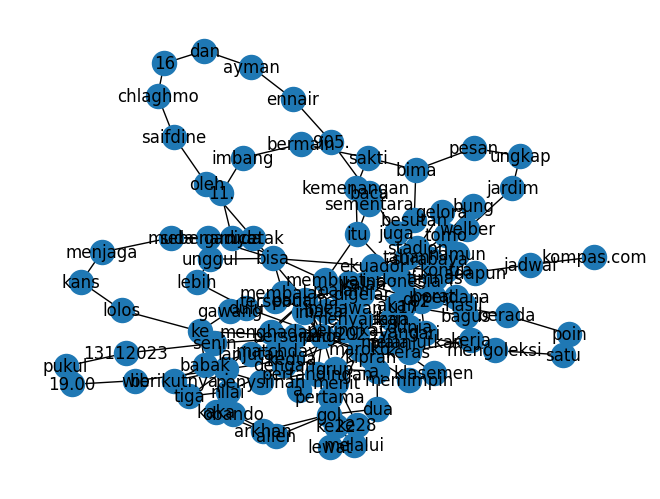

In [18]:
# nx.draw(G)
graf = nx.draw(G, with_labels = True)
graf

In [19]:
# Cuma cek Hitung centrality pada berita 1 dengan closeness
closeness_centrality = nx.closeness_centrality(G)
closeness_centrality

{'u17': 0.2791762013729977,
 'indonesia': 0.31362467866323906,
 '2023': 0.25,
 'laga': 0.3104325699745547,
 'dunia': 0.24897959183673468,
 'timnas': 0.29397590361445786,
 'kaka': 0.22676579925650558,
 '.': 0.2772727272727273,
 'arkhan': 0.21403508771929824,
 'dua': 0.22385321100917432,
 'gol': 0.25206611570247933,
 'a.': 0.2601279317697228,
 'lewat': 0.20299500831946754,
 'ke22': 0.21863799283154123,
 'ini': 0.27539503386004516,
 'pada': 0.3630952380952381,
 'malam': 0.25051334702258726,
 'ungkap': 0.18074074074074073,
 'pesan': 0.1737891737891738,
 'jardim': 0.21180555555555555,
 'grup': 0.2623655913978495,
 'a': 0.2147887323943662,
 'piala': 0.291866028708134,
 'kedua': 0.2525879917184265,
 'pertama': 0.23062381852551986,
 'penysiihan': 0.215929203539823,
 'akan': 0.25957446808510637,
 'besutan': 0.24646464646464647,
 'adapun': 0.23921568627450981,
 'juga': 0.25311203319502074,
 'vs': 0.2850467289719626,
 'yang': 0.27790432801822323,
 'tahan': 0.2606837606837607,
 'bisa': 0.247967479

In [20]:
# Mengurutkan peringkat kata-kata berdasarkan centrality
sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

a = 0

print("Peringkat Kata dari PageRank Centrality:")
for word, rank in sorted_centrality:
    a+=1
    print(f"{a}. '{word}': {rank}")

Peringkat Kata dari PageRank Centrality:
1. 'pada': 0.03526438286495523
2. ',': 0.03048099740848135
3. 'indonesia': 0.02712827706902072
4. 'panama': 0.025956652264840622
5. 'u17': 0.023052738981091503
6. '.': 0.017524335544940928
7. 'grup': 0.016648249294331913
8. 'laga': 0.01640145158203671
9. 'gol': 0.015507726037539027
10. 'piala': 0.014553284304832506
11. 'di': 0.014239009201413005
12. 'maroko': 0.01422871682730897
13. 'ekuador': 0.01345085033544605
14. 'timnas': 0.013384790658290645
15. 'dunia': 0.013002328785572125
16. '2023': 0.011170742326813633
17. 'sakti': 0.010950613782967248
18. 'muda': 0.01082490750808971
19. 'bima': 0.010767173375946036
20. 'ke': 0.010731076311384018
21. 'garuda': 0.010558085570929694
22. 'itu': 0.010549590111743414
23. 'bisa': 0.010399379516673316
24. 'babak': 0.010297092897829332
25. 'menit': 0.009926811894002761
26. 'yang': 0.009869441133939005
27. 'membuat': 0.009772952721955531
28. 'akan': 0.009663692260771947
29. 'kedua': 0.009526954664047179
30. 'd

In [21]:
# Mengambil lima kata teratas
top_5_words = sorted_centrality[:5]

# Membuat DataFrame dari lima kata teratas
top_5_df = pd.DataFrame(top_5_words, columns=['Kata', 'Centrality'])
print(top_5_df)

        Kata  Centrality
0       pada    0.035264
1          ,    0.030481
2  indonesia    0.027128
3     panama    0.025957
4        u17    0.023053
